In [2]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

In [3]:
class ChessBoard_gym(Env):
    
    def set_startpos(self):
        self.chess_board = np.zeros((8,8))
#         self.chess_board[0]=[1,2,3,4,5,6,7,8]
#         self.chess_board[1]=[9,10,11,12,13,14,15,16]
#         self.chess_board[6]=[25,26,27,28,29,30,31,32]
#         self.chess_board[7]=[17,18,19,20,21,22,23,24]
#         print("chess board - start position \n", self.chess_board)
        self.chess_board[0]=[1,0,0,0,0,0,0,8]
        self.chess_board[1]=[0,0,0,0,0,0,0,0]
        self.chess_board[6]=[0,0,0,0,0,0,0,0]
        self.chess_board[7]=[17,0,0,0,0,0,0,24]
        
    def __init__(self):
        super(ChessBoard_gym, self).__init__()
        self.chess_piece_ids = {0: 'BL', 1:'wr1',2:'wn1',3:'wb1',4:'wq',5:'wk',6:'wb2',7:'wn2',8:'wr2',9:'wp1',10:'wp2',11:'wp3',12:'wp4',13:'wp5',14:'wp6',15:'wp7',16:'wp8',
                              17:'br1',18:'bn1',19:'bb1',20:'bq',21:'bk',22:'bb2',23:'bn2',24:'br2',25:'bp1',26:'bp2',27:'bp3',28:'bp4',29:'bp5',30:'bp6',31:'bp7',32:'bp8'}

        self.chess_id2type = {1:'R',2:'N',3:'B',4:'Q',5:'K',6:'B',7:'N',8:'R',9:'P',10:'P',11:'P',12:'P',13:'P',14:'P',15:'P',16:'P',
                              17:'r',18:'n',19:'b',20:'q',21:'k',22:'b',23:'n',24:'r',25:'p',26:'p',27:'p',28:'p',29:'p',30:'p',31:'p',32:'p'}

        self.action_meanings =  {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "URC", 5:"ULC" , 6:"DRC", 7:"DLC", 8:"NLU", 9:"NRU", 10: "NLD", 11:"NRD"}
        
        self.set_startpos()
        self.observation_space = self.chess_board
        
        
        self.set_valid_actions()
        
        # Define an action space ranging from 0 to 12
        self.action_space = spaces.Discrete(112,)
                        
        # Create a canvas to render the environment images upon 
#         self.canvas = np.ones(self.observation_shape) * 1
        
        
        # Maximum number of tries for legal move
        self.max_tries = 100000
        self.turn = "w"

    
    def reset(self):
        # Reset the fuel consumed
        self.moves_left = self.max_tries

        self.set_startpos()

        # Reset the reward
        self.ep_return  = 0
        return(self.chess_board)

    
    def print_board(self):
        print("\n\n")
        for i in range(7,-1,-1):
            rank = ""
            for j in range(0,8):
                rank = rank + self.chess_piece_ids.get(self.chess_board[i,j]) + " - "
            print(rank,"\n")
        print("\n\n")       
    
    def get_FEN(self):
        FEN_String = ""
        empty_cell_count = 0
        for i in range(7,-1,-1):
            rank = ""
            for j in range(0,8):
                if (self.chess_board[i,j] == 0):
                    empty_cell_count = empty_cell_count + 1
                else:
                    if empty_cell_count > 0:
                        rank = rank + str(empty_cell_count)
                        empty_cell_count = 0
                    rank = rank + self.chess_id2type.get(self.chess_board[i,j]) 
#             print("empty cell count:", empty_cell_count, "rank:", rank)
            if empty_cell_count > 0:
                rank = rank + str(empty_cell_count)
                empty_cell_count = 0
                
            if (i <= 7 ): 
                FEN_String = FEN_String + rank 
                if (i != 0 ): FEN_String = FEN_String + "/"
        return(FEN_String)
    
    def get_chess_piece_color(self, id):
        if id <= 16 :
            return "w"
        elif id <=32:
            return "b"
        else:
            return "I"
    
    def set_valid_actions (self):
        self.chesspiece_actions = {"r": [0,1,2,3],
                                   "b": [4,5,6,7],
                                   "p": [3,4,5],
                                   "n": [8,9,10,11],
                                   "k": [0,1,2,3,4,5,6,7],
                                   "q": [0,1,2,3,4,5,6,7],
                                   "R": [0,1,2,3],
                                   "B": [4,5,6,7],
                                   "P": [3,4,5],
                                   "N": [8,9,10,11],
                                   "K": [0,1,2,3,4,5,6,7],
                                   "Q": [0,1,2,3,4,5,6,7]                                   
                                  }
        self.complete_actions_list = [[1,0,1],[1,0,2],[1,0,3],[1,0,4],[1,0,5],[1,0,6],[1,0,7], # Rook
                             [1,1,1],[1,1,2],[1,1,3],[1,1,4],[1,1,5],[1,1,6],[1,1,7],
                             [1,2,1],[1,2,2],[1,2,3],[1,2,4],[1,2,5],[1,2,6],[1,2,7],
                             [1,3,1],[1,3,2],[1,3,3],[1,3,4],[1,3,5],[1,3,6],[1,3,7],
                             [8,0,1],[8,0,2],[8,0,3],[8,0,4],[8,0,5],[8,0,6],[8,0,7],
                             [8,1,1],[8,1,2],[8,1,3],[8,1,4],[8,1,5],[8,1,6],[8,1,7],
                             [8,2,1],[8,2,2],[8,2,3],[8,2,4],[8,2,5],[8,2,6],[8,2,7],
                             [8,3,1],[8,3,2],[8,3,3],[8,3,4],[8,3,5],[8,3,6],[8,3,7],  
                             [17,0,1],[17,0,2],[17,0,3],[17,0,4],[17,0,5],[17,0,6],[17,0,7],
                             [17,1,1],[17,1,2],[17,1,3],[17,1,4],[17,1,5],[17,1,6],[17,1,7],
                             [17,2,1],[17,2,2],[17,2,3],[17,2,4],[17,2,5],[17,2,6],[17,2,7],
                             [17,3,1],[17,3,2],[17,3,3],[17,3,4],[17,3,5],[17,3,6],[17,3,7],   
                             [24,0,1],[24,0,2],[24,0,3],[24,0,4],[24,0,5],[24,0,6],[24,0,7],
                             [24,1,1],[24,1,2],[24,1,3],[24,1,4],[24,1,5],[24,1,6],[24,1,7],
                             [24,2,1],[24,2,2],[24,2,3],[24,2,4],[24,2,5],[24,2,6],[24,2,7],
                             [24,3,1],[24,3,2],[24,3,3],[24,3,4],[24,3,5],[24,3,6],[24,3,7],     
                             [3,4,1],[3,4,2],[3,4,3],[3,4,4],[3,4,5],[3,4,6],[3,4,7],  #Bishop
                             [3,5,1],[3,5,2],[3,5,3],[3,5,4],[3,5,5],[3,5,6],[3,5,7],
                             [3,6,1],[3,6,2],[3,6,3],[3,6,4],[3,6,5],[3,6,6],[3,6,7],
                             [3,7,1],[3,7,2],[3,7,3],[3,7,4],[3,7,5],[3,7,6],[3,7,7],     
                             [6,4,1],[6,4,2],[6,4,3],[6,4,4],[6,4,5],[6,4,6],[6,4,7],
                             [6,5,1],[6,5,2],[6,5,3],[6,5,4],[6,5,5],[6,5,6],[6,5,7],
                             [6,6,1],[6,6,2],[6,6,3],[6,6,4],[6,6,5],[6,6,6],[6,6,7],
                             [6,7,1],[6,7,2],[6,7,3],[6,7,4],[6,7,5],[6,7,6],[6,7,7],                                      
                             [19,4,1],[19,4,2],[19,4,3],[19,4,4],[19,4,5],[19,4,6],[19,4,7],
                             [19,5,1],[19,5,2],[19,5,3],[19,5,4],[19,5,5],[19,5,6],[19,5,7],
                             [19,6,1],[19,6,2],[19,6,3],[19,6,4],[19,6,5],[19,6,6],[19,6,7],
                             [19,7,1],[19,7,2],[19,7,3],[19,7,4],[19,7,5],[19,7,6],[19,7,7],    
                             [22,4,1],[22,4,2],[22,4,3],[22,4,4],[22,4,5],[22,4,6],[22,4,7],
                             [22,5,1],[22,5,2],[22,5,3],[22,5,4],[22,5,5],[22,5,6],[22,5,7],
                             [22,6,1],[22,6,2],[22,6,3],[22,6,4],[22,6,5],[22,6,6],[22,6,7],
                             [22,7,1],[22,7,2],[22,7,3],[22,7,4],[22,7,5],[22,7,6],[22,7,7],     
                             [4,0,1],[4,0,2],[4,0,3],[4,0,4],[4,0,5],[4,0,6],[4,0,7], #Queen
                             [4,1,1],[4,1,2],[4,1,3],[4,1,4],[4,1,5],[4,1,6],[4,1,7],
                             [4,2,1],[4,2,2],[4,2,3],[4,2,4],[4,2,5],[4,2,6],[4,2,7],
                             [4,3,1],[4,3,2],[4,3,3],[4,3,4],[4,3,5],[4,3,6],[4,3,7],   
                             [4,4,1],[4,4,2],[4,4,3],[4,4,4],[4,4,5],[4,4,6],[4,4,7],
                             [4,5,1],[4,5,2],[4,5,3],[4,5,4],[4,5,5],[4,5,6],[4,5,7],
                             [4,6,1],[4,6,2],[4,6,3],[4,6,4],[4,6,5],[4,6,6],[4,6,7],
                             [4,7,1],[4,7,2],[4,7,3],[4,7,4],[4,7,5],[4,7,6],[4,7,7],                                       
                             [20,0,1],[20,0,2],[20,0,3],[20,0,4],[20,0,5],[20,0,6],[20,0,7],
                             [20,1,1],[20,1,2],[20,1,3],[20,1,4],[20,1,5],[20,1,6],[20,1,7],
                             [20,2,1],[20,2,2],[20,2,3],[20,2,4],[20,2,5],[20,2,6],[20,2,7],
                             [20,3,1],[20,3,2],[20,3,3],[20,3,4],[20,3,5],[20,3,6],[20,3,7],   
                             [20,4,1],[20,4,2],[20,4,3],[20,4,4],[20,4,5],[20,4,6],[20,4,7],
                             [20,5,1],[20,5,2],[20,5,3],[20,5,4],[20,5,5],[20,5,6],[20,5,7],
                             [20,6,1],[20,6,2],[20,6,3],[20,6,4],[20,6,5],[20,6,6],[20,6,7],
                             [20,7,1],[20,7,2],[20,7,3],[20,7,4],[20,7,5],[20,7,6],[20,7,7],  
                             [7,8,1],[7,9,1], [7,10,1],[7,11,1],  #Knight
                             [18,8,1],[18,9,1], [18,10,1],[18,11,1],
                             [23,8,1],[23,9,1], [23,10,1],[23,11,1],
                             [2,8,1],[2,9,1], [2,10,1],[2,11,1],
                             [9,0,1],[9,1,1], [9,2,1],[9,3,1],     #Pawns    
                             [10,0,1],[10,1,1], [10,2,1],[10,3,1],
                             [11,0,1],[11,1,1], [11,2,1],[11,3,1],
                             [12,0,1],[12,1,1], [12,2,1],[12,3,1],
                             [13,0,1],[13,1,1], [13,2,1],[13,3,1],
                             [14,0,1],[14,1,1], [14,2,1],[14,3,1],
                             [15,0,1],[15,1,1], [15,2,1],[15,3,1],
                             [16,0,1],[16,1,1], [16,2,1],[16,3,1],
                             [25,0,1],[25,1,1], [25,2,1],[25,3,1],
                             [26,0,1],[26,1,1], [26,2,1],[26,3,1],
                             [27,0,1],[27,1,1], [27,2,1],[27,3,1],  
                             [28,0,1],[28,1,1], [28,2,1],[28,3,1],
                             [29,0,1],[29,1,1], [29,2,1],[29,3,1],
                             [30,0,1],[30,1,1], [30,2,1],[30,3,1],
                             [31,0,1],[31,1,1], [31,2,1],[31,3,1],
                             [32,0,1],[32,1,1], [32,2,1],[32,3,1],
                             [5,0,1],[5,1,1], [5,2,1],[5,3,1],  #King
                             [21,0,1],[21,1,1], [21,2,1],[21,3,1]
                                     ]
        
    def get_valid_actions(self, piece_type):
        return self.chesspiece_actions.get(piece_type)
    
    def check_any_pieces_in_between(self, start_cell, end_cell,  straight = True):
#       For rook and queen
        x_min = np.min([start_cell[0], end_cell[0]])
        x_max = np.max([start_cell[0], end_cell[0]])
        y_min = np.min([start_cell[1], end_cell[1]])
        y_max = np.max([start_cell[1], end_cell[1]])

#         print("x_min, x_max, y_min, y_max ", x_min,":",x_max, ":", y_min, ":",y_max)
       
        if straight:
            
#           on the same row
            if (x_min == x_max):
                for j in range( y_min +1, y_max):
#                     print("Pieces in between: ", self.chess_board[x_min,j], " pos:", x_min, ":", j)
                    if self.chess_board[x_min,j] != 0:
                        return( True)
            
            if (y_min == y_max):
                for i in range( x_min +1, x_max):
#                     print("Pieces in between: ", self.chess_board[i,y_min], " pos:", i, ":", y_min)
                    if self.chess_board[i,y_min] != 0:
                        return( True)
                    
#       for bishop and queen
        else:
            for i in range(x_min, x_max):
                for j in range(y_min, y_max):
                    if self.chess_board[i,j] != 0:
                        return( True)
    
        return( False)
                        
            
            
            
            
    def step(self, action_id):
        # Flag that marks the termination of an episode
        done = False
        x=-1
        y=-1
        
        action_details = self.complete_actions_list[action_id]
        pick_piece = action_details[0]
        action = action_details[1]
        num_cells = action_details[2]        
        
        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"
        
        # Decrease the fuel counter 
        self.moves_left -= 1 
 
        
#         if (self.turn == "w"):
#             pick_piece = np.random.randint(1,17)
#         else:
#             pick_piece = np.random.randint(17,32)
        
#         print('select chess piece id:', pick_piece)
        piece_color = self.get_chess_piece_color(pick_piece)
        piece_type = self.chess_id2type.get(pick_piece)
        valid_actions = self.get_valid_actions(piece_type)
        current_pos = np.where(self.chess_board == pick_piece)
        reward = 0
        
#         num_cells = np.random.randint(1,7)
        if action not in valid_actions:
            reward = -1      
        
        if num_cells > 1 and piece_type not in ['r','b','q']:
            reward = -1

#             {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "URC", 5:"ULC" , 6:"BRC", 7:"BLC", 8:"NLU", 9:"NRU", 10: "NLD", 11:"NRD",12: "Do Nothing"}
            
        if ( (action ==0 and piece_color == "w") or (action ==1 and piece_color == "b")):
            x = current_pos[0]
            y = current_pos[1]  + num_cells
        elif ( (action ==1 and piece_color == "w") or (action ==0 and piece_color == "b")):
            x = current_pos[0]
            y = current_pos[1]  - num_cells
        elif ( (action ==2 and piece_color == "w") or (action ==3 and piece_color == "b")):
            x = current_pos[0] - num_cells
            y = current_pos[1] 
        elif ( (action ==3 and piece_color == "w") or (action ==2 and piece_color == "b")):
            x = current_pos[0] + num_cells
            y = current_pos[1] 
        elif ( (action ==4 and piece_color == "w") or (action ==6 and piece_color == "b")):
            x = current_pos[0] + num_cells 
            y = current_pos[1] + num_cells
        elif ( (action ==5 and piece_color == "w") or (action ==7 and piece_color == "b")):
            x = current_pos[0] + num_cells 
            y = current_pos[1] - num_cells
        elif ( (action ==6 and piece_color == "w") or (action ==4 and piece_color == "b")):
            x = current_pos[0] + num_cells 
            y = current_pos[1] - num_cells
        elif ( (action ==7 and piece_color == "w") or (action ==5 and piece_color == "b")):
            x = current_pos[0] - num_cells 
            y = current_pos[1] - num_cells
        elif ( (action ==8 and piece_color == "w") or (action ==10 and piece_color == "b")):
            x = current_pos[0] - 1 
            y = current_pos[1] + 2
        elif ( (action ==9 and piece_color == "w") or (action ==11 and piece_color == "b")):
            x = current_pos[0] + 1 
            y = current_pos[1] + 2
        elif ( (action ==10 and piece_color == "w") or (action ==8 and piece_color == "b")):
            x = current_pos[0] - 1 
            y = current_pos[1] - 2
        elif ( (action ==11 and piece_color == "w") or (action ==9 and piece_color == "b")):
            x = current_pos[0] + 1 
            y = current_pos[1] - 2
        
        if (x < 0 or x > 7 or y < 0 or y > 7):
            reward = -1
        
        if(x >=0 and y >=0  and reward != -1):
            next_pos_piece = self.chess_board[x,y]
#             print("Next chess position: ", next_pos_piece)
#           Making sure same color piece already exists in the new position
            if next_pos_piece[0] > 0:
                next_piece_color = self.get_chess_piece_color(next_pos_piece[0])
                next_piece_type = self.chess_id2type.get(next_pos_piece[0])
#                 print("Next piece color: ", next_piece_color, " current piece color:", piece_color)
                if next_piece_color == piece_color:
                    reward = -1
            else:
#               if it is pawn, it cannot go across
                if (piece_type.lower() == 'p' and action in [4,5]):
                    reward = -1
#           check whether any pieces in between 
            if (num_cells >= 2):
#               for rook and Queeen straight moves
                if action in [0,1,2,3]:
                    if self.check_any_pieces_in_between( current_pos, [x,y],  True):
                        reward = -1
#               for bishop and Queeen straight moves
                elif action in [4,5,6,7]:
                    if self.check_any_pieces_in_between(current_pos, [x,y], False):
                        reward = -1
                    
                
        if (reward != -1):
            reward = 1
#             print("action taken is: ", self.action_meanings.get(action), 'chess piece:' , self.chess_piece_ids.get(pick_piece), ' num cells:', num_cells,
#                   ' current pos: ', current_pos, ' New pos:', [x,y])
            self.chess_board[current_pos] = 0
            self.chess_board[x,y] = pick_piece
#           switch the turn
            if (self.turn == "w"):
                self.turn = "b"
            else:
                self.turn = "w"
       
            self.ep_return += 1
        
        # Draw elements on the canvas
#         self.draw_elements_on_canvas()

        # If number of moves over, then mark it as done
        if (self.moves_left == 0 or reward ==1):
            done = True

        return  self.chess_board, reward, done, []        



In [4]:
env = ChessBoard_gym()
obs = env.reset()
# plt.imshow(obs)

chess board - start position 
 [[ 1.  2.  3.  4.  5.  6.  7.  8.]
 [ 9. 10. 11. 12. 13. 14. 15. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [25. 26. 27. 28. 29. 30. 31. 32.]
 [17. 18. 19. 20. 21. 22. 23. 24.]]
chess board - start position 
 [[ 1.  2.  3.  4.  5.  6.  7.  8.]
 [ 9. 10. 11. 12. 13. 14. 15. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [25. 26. 27. 28. 29. 30. 31. 32.]
 [17. 18. 19. 20. 21. 22. 23. 24.]]


In [17]:
%matplotlib inline
from reportlab.graphics import renderPM
import chess
import chess.svg
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from PIL import Image
import re
import glob
import PIL
import matplotlib.image as mpimg

def fen_to_image(fen):
    board = chess.Board(fen)
    current_board = chess.svg.board(board=board)

    output_file = open('current_board.svg', "w")
    output_file.write(current_board)
    output_file.close()

    svg = svg2rlg('current_board.svg')
    renderPM.drawToFile(svg, 'current_board.png', fmt="PNG")
    return board

chess board - start position 
 [[ 1.  2.  3.  4.  5.  6.  7.  8.]
 [ 9. 10. 11. 12. 13. 14. 15. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [25. 26. 27. 28. 29. 30. 31. 32.]
 [17. 18. 19. 20. 21. 22. 23. 24.]]
chess board - start position 
 [[ 1.  2.  3.  4.  5.  6.  7.  8.]
 [ 9. 10. 11. 12. 13. 14. 15. 16.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [25. 26. 27. 28. 29. 30. 31. 32.]
 [17. 18. 19. 20. 21. 22. 23. 24.]]
action taken is:  Up chess piece: wp3  num cells: 1  current pos:  (array([1], dtype=int64), array([2], dtype=int64))  New pos: [array([2], dtype=int64), array([2], dtype=int64)]
FEN String rnbqkbnr/pppppppp/8/8/8/2P5/PP1PPPPP/RNBQKBNR 


action taken is:  Up chess piece: bp4  num cells: 1  current pos:  (array([6], dtype=int64), array([3], dtype=int64))  New pos: [array([5

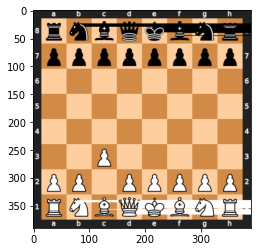

action taken is:  ULC chess piece: wq  num cells: 1  current pos:  (array([0], dtype=int64), array([3], dtype=int64))  New pos: [array([1], dtype=int64), array([2], dtype=int64)]
FEN String rnbqkbnr/ppp1pppp/3p4/8/8/2P5/PPQPPPPP/RNB1KBNR 




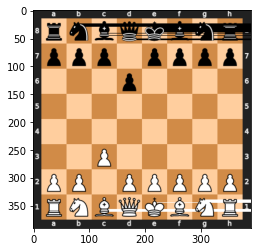

action taken is:  Up chess piece: bp6  num cells: 1  current pos:  (array([6], dtype=int64), array([5], dtype=int64))  New pos: [array([5], dtype=int64), array([5], dtype=int64)]
FEN String rnbqkbnr/ppp1p1pp/3p1p2/8/8/2P5/PPQPPPPP/RNB1KBNR 




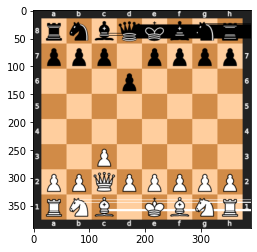

action taken is:  Up chess piece: wp4  num cells: 1  current pos:  (array([1], dtype=int64), array([3], dtype=int64))  New pos: [array([2], dtype=int64), array([3], dtype=int64)]
FEN String rnbqkbnr/ppp1p1pp/3p1p2/8/8/2PP4/PPQ1PPPP/RNB1KBNR 




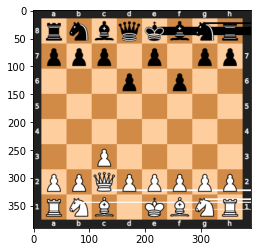

action taken is:  Up chess piece: bp6  num cells: 1  current pos:  (array([5], dtype=int64), array([5], dtype=int64))  New pos: [array([4], dtype=int64), array([5], dtype=int64)]
FEN String rnbqkbnr/ppp1p1pp/3p4/5p2/8/2PP4/PPQ1PPPP/RNB1KBNR 




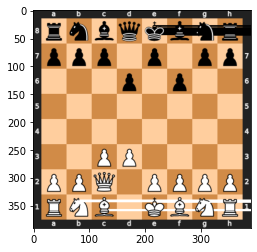

action taken is:  ULC chess piece: wk  num cells: 1  current pos:  (array([0], dtype=int64), array([4], dtype=int64))  New pos: [array([1], dtype=int64), array([3], dtype=int64)]
FEN String rnbqkbnr/ppp1p1pp/3p4/5p2/8/2PP4/PPQKPPPP/RNB2BNR 




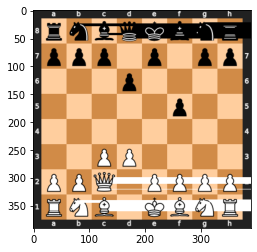

action taken is:  Up chess piece: bp6  num cells: 1  current pos:  (array([4], dtype=int64), array([5], dtype=int64))  New pos: [array([3], dtype=int64), array([5], dtype=int64)]
FEN String rnbqkbnr/ppp1p1pp/3p4/8/5p2/2PP4/PPQKPPPP/RNB2BNR 




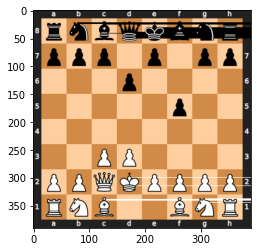

action taken is:  Up chess piece: wp4  num cells: 1  current pos:  (array([2], dtype=int64), array([3], dtype=int64))  New pos: [array([3], dtype=int64), array([3], dtype=int64)]
FEN String rnbqkbnr/ppp1p1pp/3p4/8/3P1p2/2P5/PPQKPPPP/RNB2BNR 




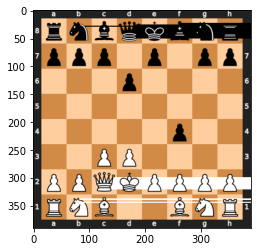

action taken is:  Up chess piece: bp5  num cells: 1  current pos:  (array([6], dtype=int64), array([4], dtype=int64))  New pos: [array([5], dtype=int64), array([4], dtype=int64)]
FEN String rnbqkbnr/ppp3pp/3pp3/8/3P1p2/2P5/PPQKPPPP/RNB2BNR 




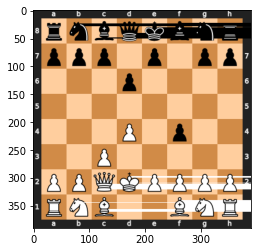

action taken is:  URC chess piece: wk  num cells: 1  current pos:  (array([1], dtype=int64), array([3], dtype=int64))  New pos: [array([2], dtype=int64), array([4], dtype=int64)]
FEN String rnbqkbnr/ppp3pp/3pp3/8/3P1p2/2P1K3/PPQ1PPPP/RNB2BNR 




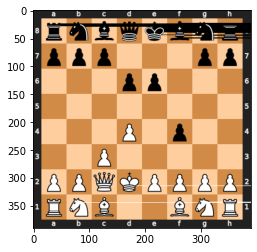

action taken is:  Up chess piece: bp4  num cells: 1  current pos:  (array([5], dtype=int64), array([3], dtype=int64))  New pos: [array([4], dtype=int64), array([3], dtype=int64)]
FEN String rnbqkbnr/ppp3pp/4p3/3p4/3P1p2/2P1K3/PPQ1PPPP/RNB2BNR 




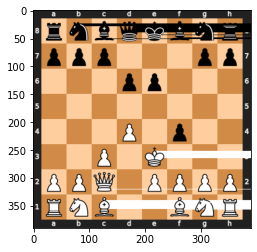

action taken is:  Right chess piece: wk  num cells: 1  current pos:  (array([2], dtype=int64), array([4], dtype=int64))  New pos: [array([2], dtype=int64), array([5], dtype=int64)]
FEN String rnbqkbnr/ppp3pp/4p3/3p4/3P1p2/2P2K2/PPQ1PPPP/RNB2BNR 




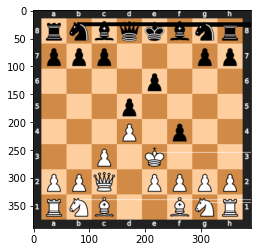

action taken is:  Up chess piece: bp3  num cells: 1  current pos:  (array([6], dtype=int64), array([2], dtype=int64))  New pos: [array([5], dtype=int64), array([2], dtype=int64)]
FEN String rnbqkbnr/pp4pp/2p1p3/3p4/3P1p2/2P2K2/PPQ1PPPP/RNB2BNR 




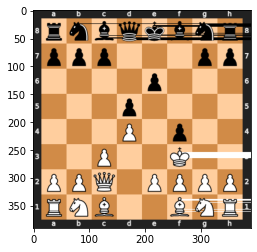

action taken is:  Up chess piece: wk  num cells: 1  current pos:  (array([2], dtype=int64), array([5], dtype=int64))  New pos: [array([3], dtype=int64), array([5], dtype=int64)]
FEN String rnbqkbnr/pp4pp/2p1p3/3p4/3P1K2/2P5/PPQ1PPPP/RNB2BNR 




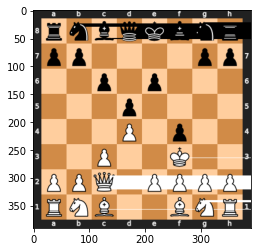

<ipython-input-3-21a5d016d139>:213: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (x < 0 or x > 7 or y < 0 or y > 7):
<ipython-input-3-21a5d016d139>:216: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if(x >=0 and y >=0  and reward != -1):


action taken is:  Up chess piece: bp2  num cells: 1  current pos:  (array([6], dtype=int64), array([1], dtype=int64))  New pos: [array([5], dtype=int64), array([1], dtype=int64)]
FEN String rnbqkbnr/p5pp/1pp1p3/3p4/3P1K2/2P5/PPQ1PPPP/RNB2BNR 




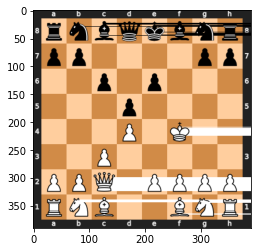

action taken is:  Right chess piece: wq  num cells: 1  current pos:  (array([1], dtype=int64), array([2], dtype=int64))  New pos: [array([1], dtype=int64), array([3], dtype=int64)]
FEN String rnbqkbnr/p5pp/1pp1p3/3p4/3P1K2/2P5/PP1QPPPP/RNB2BNR 




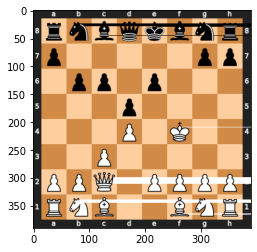

action taken is:  ULC chess piece: bk  num cells: 1  current pos:  (array([7], dtype=int64), array([4], dtype=int64))  New pos: [array([6], dtype=int64), array([3], dtype=int64)]
FEN String rnbq1bnr/p2k2pp/1pp1p3/3p4/3P1K2/2P5/PP1QPPPP/RNB2BNR 




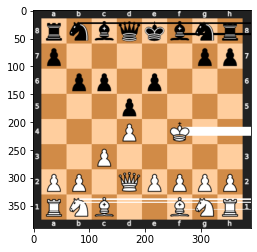

action taken is:  Up chess piece: wq  num cells: 1  current pos:  (array([1], dtype=int64), array([3], dtype=int64))  New pos: [array([2], dtype=int64), array([3], dtype=int64)]
FEN String rnbq1bnr/p2k2pp/1pp1p3/3p4/3P1K2/2PQ4/PP2PPPP/RNB2BNR 




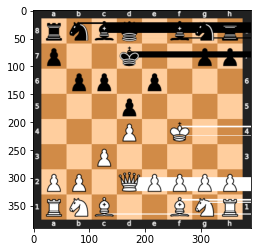

action taken is:  ULC chess piece: bb1  num cells: 1  current pos:  (array([7], dtype=int64), array([2], dtype=int64))  New pos: [array([6], dtype=int64), array([1], dtype=int64)]
FEN String rn1q1bnr/pb1k2pp/1pp1p3/3p4/3P1K2/2PQ4/PP2PPPP/RNB2BNR 




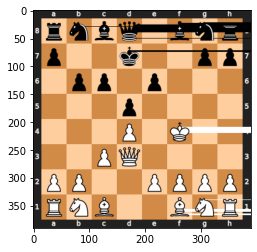

action taken is:  NRU chess piece: wn1  num cells: 1  current pos:  (array([0], dtype=int64), array([1], dtype=int64))  New pos: [array([1], dtype=int64), array([3], dtype=int64)]
FEN String rn1q1bnr/pb1k2pp/1pp1p3/3p4/3P1K2/2PQ4/PP1NPPPP/R1B2BNR 




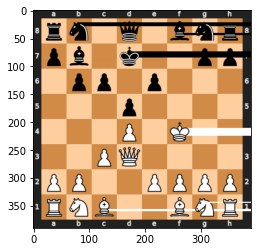

action taken is:  BRC chess piece: bk  num cells: 1  current pos:  (array([6], dtype=int64), array([3], dtype=int64))  New pos: [array([7], dtype=int64), array([4], dtype=int64)]
FEN String rn1qkbnr/pb4pp/1pp1p3/3p4/3P1K2/2PQ4/PP1NPPPP/R1B2BNR 




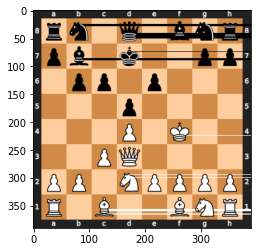

action taken is:  NRD chess piece: wn1  num cells: 1  current pos:  (array([1], dtype=int64), array([3], dtype=int64))  New pos: [array([2], dtype=int64), array([1], dtype=int64)]
FEN String rn1qkbnr/pb4pp/1pp1p3/3p4/3P1K2/1NPQ4/PP2PPPP/R1B2BNR 




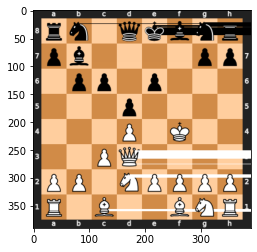

action taken is:  NLU chess piece: bn2  num cells: 1  current pos:  (array([7], dtype=int64), array([6], dtype=int64))  New pos: [array([6], dtype=int64), array([4], dtype=int64)]
FEN String rn1qkb1r/pb2n1pp/1pp1p3/3p4/3P1K2/1NPQ4/PP2PPPP/R1B2BNR 




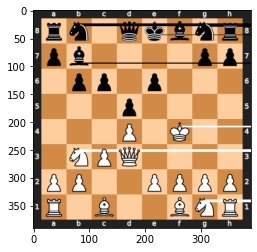

action taken is:  Up chess piece: wp8  num cells: 1  current pos:  (array([1], dtype=int64), array([7], dtype=int64))  New pos: [array([2], dtype=int64), array([7], dtype=int64)]
FEN String rn1qkb1r/pb2n1pp/1pp1p3/3p4/3P1K2/1NPQ3P/PP2PPP1/R1B2BNR 




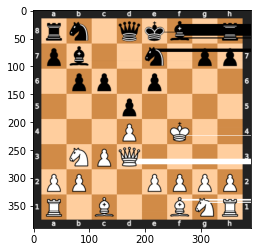

action taken is:  NRU chess piece: bn2  num cells: 1  current pos:  (array([6], dtype=int64), array([4], dtype=int64))  New pos: [array([7], dtype=int64), array([2], dtype=int64)]
FEN String rnnqkb1r/pb4pp/1pp1p3/3p4/3P1K2/1NPQ3P/PP2PPP1/R1B2BNR 




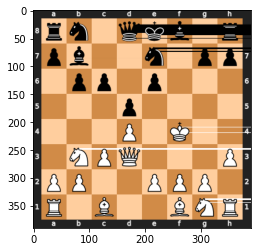

action taken is:  ULC chess piece: wq  num cells: 1  current pos:  (array([2], dtype=int64), array([3], dtype=int64))  New pos: [array([3], dtype=int64), array([2], dtype=int64)]
FEN String rnnqkb1r/pb4pp/1pp1p3/3p4/2QP1K2/1NP4P/PP2PPP1/R1B2BNR 




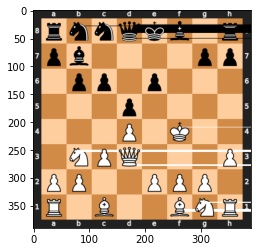

action taken is:  ULC chess piece: bp4  num cells: 1  current pos:  (array([4], dtype=int64), array([3], dtype=int64))  New pos: [array([3], dtype=int64), array([2], dtype=int64)]
FEN String rnnqkb1r/pb4pp/1pp1p3/8/2pP1K2/1NP4P/PP2PPP1/R1B2BNR 




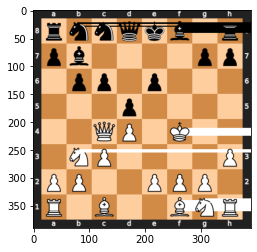

action taken is:  BLC chess piece: wk  num cells: 1  current pos:  (array([3], dtype=int64), array([5], dtype=int64))  New pos: [array([2], dtype=int64), array([4], dtype=int64)]
FEN String rnnqkb1r/pb4pp/1pp1p3/8/2pP4/1NP1K2P/PP2PPP1/R1B2BNR 




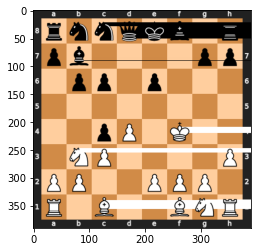

action taken is:  ULC chess piece: bp4  num cells: 1  current pos:  (array([3], dtype=int64), array([2], dtype=int64))  New pos: [array([2], dtype=int64), array([1], dtype=int64)]
FEN String rnnqkb1r/pb4pp/1pp1p3/8/3P4/1pP1K2P/PP2PPP1/R1B2BNR 




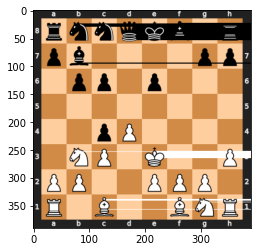

action taken is:  NRD chess piece: wn1  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnnqkb1r/pb4pp/1pp1p3/8/3P4/1pP1K2P/PP2PPP1/R1B2BNR 




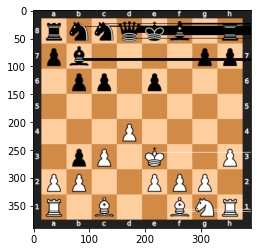

action taken is:  Up chess piece: bp7  num cells: 1  current pos:  (array([6], dtype=int64), array([6], dtype=int64))  New pos: [array([5], dtype=int64), array([6], dtype=int64)]
FEN String rnnqkb1r/pb5p/1pp1p1p1/8/3P4/1pP1K2P/PP2PPP1/R1B2BNR 




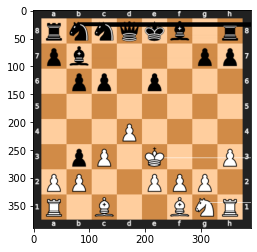

action taken is:  Left chess piece: wq  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnnqkb1r/pb5p/1pp1p1p1/8/3P4/1pP1K2P/PP2PPP1/R1B2BNR 




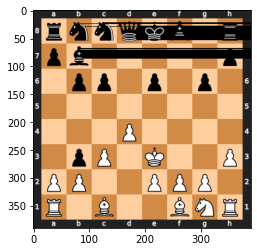

action taken is:  ULC chess piece: bq  num cells: 1  current pos:  (array([7], dtype=int64), array([3], dtype=int64))  New pos: [array([6], dtype=int64), array([2], dtype=int64)]
FEN String rnn1kb1r/pbq4p/1pp1p1p1/8/3P4/1pP1K2P/PP2PPP1/R1B2BNR 




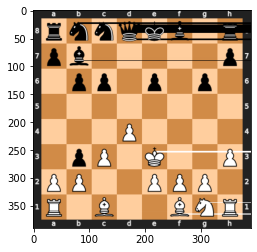

action taken is:  NRD chess piece: wn1  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnn1kb1r/pbq4p/1pp1p1p1/8/3P4/1pP1K2P/PP2PPP1/R1B2BNR 




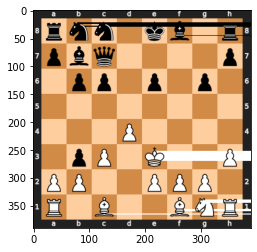

action taken is:  Left chess piece: bq  num cells: 4  current pos:  (array([6], dtype=int64), array([2], dtype=int64))  New pos: [array([6], dtype=int64), array([6], dtype=int64)]
FEN String rnn1kb1r/pb4qp/1pp1p1p1/8/3P4/1pP1K2P/PP2PPP1/R1B2BNR 




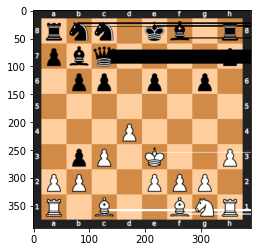

action taken is:  Up chess piece: wp2  num cells: 1  current pos:  (array([1], dtype=int64), array([1], dtype=int64))  New pos: [array([2], dtype=int64), array([1], dtype=int64)]
FEN String rnn1kb1r/pb4qp/1pp1p1p1/8/3P4/1PP1K2P/P3PPP1/R1B2BNR 




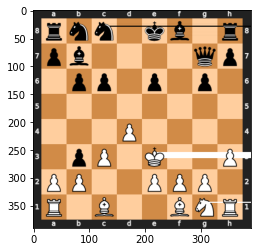

action taken is:  Right chess piece: bq  num cells: 2  current pos:  (array([6], dtype=int64), array([6], dtype=int64))  New pos: [array([6], dtype=int64), array([4], dtype=int64)]
FEN String rnn1kb1r/pb2q2p/1pp1p1p1/8/3P4/1PP1K2P/P3PPP1/R1B2BNR 




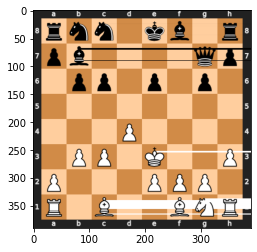

action taken is:  BRC chess piece: wb1  num cells: 1  current pos:  (array([0], dtype=int64), array([2], dtype=int64))  New pos: [array([1], dtype=int64), array([1], dtype=int64)]
FEN String rnn1kb1r/pb2q2p/1pp1p1p1/8/3P4/1PP1K2P/PB2PPP1/R4BNR 




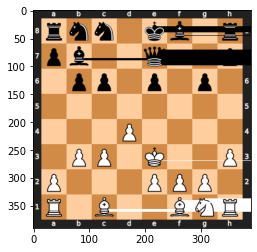

action taken is:  Up chess piece: bp2  num cells: 1  current pos:  (array([5], dtype=int64), array([1], dtype=int64))  New pos: [array([4], dtype=int64), array([1], dtype=int64)]
FEN String rnn1kb1r/pb2q2p/2p1p1p1/1p6/3P4/1PP1K2P/PB2PPP1/R4BNR 




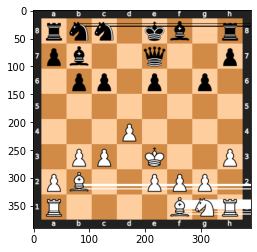

action taken is:  BRC chess piece: wq  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnn1kb1r/pb2q2p/2p1p1p1/1p6/3P4/1PP1K2P/PB2PPP1/R4BNR 




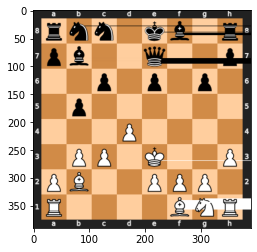

action taken is:  URC chess piece: bq  num cells: 1  current pos:  (array([6], dtype=int64), array([4], dtype=int64))  New pos: [array([7], dtype=int64), array([3], dtype=int64)]
FEN String rnnqkb1r/pb5p/2p1p1p1/1p6/3P4/1PP1K2P/PB2PPP1/R4BNR 




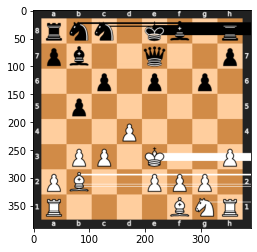

action taken is:  URC chess piece: wk  num cells: 1  current pos:  (array([2], dtype=int64), array([4], dtype=int64))  New pos: [array([3], dtype=int64), array([5], dtype=int64)]
FEN String rnnqkb1r/pb5p/2p1p1p1/1p6/3P1K2/1PP4P/PB2PPP1/R4BNR 




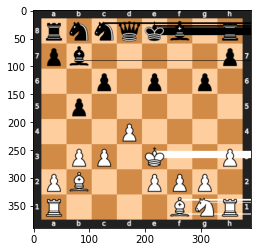

action taken is:  Right chess piece: br2  num cells: 1  current pos:  (array([7], dtype=int64), array([7], dtype=int64))  New pos: [array([7], dtype=int64), array([6], dtype=int64)]
FEN String rnnqkbr1/pb5p/2p1p1p1/1p6/3P1K2/1PP4P/PB2PPP1/R4BNR 




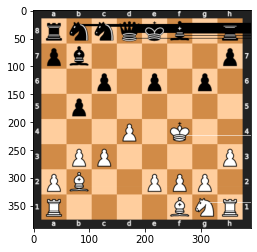

action taken is:  NLU chess piece: wn1  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnnqkbr1/pb5p/2p1p1p1/1p6/3P1K2/1PP4P/PB2PPP1/R4BNR 




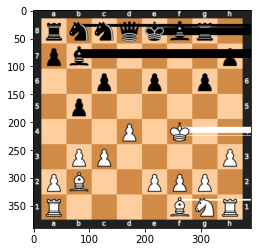

action taken is:  NLD chess piece: bn1  num cells: 1  current pos:  (array([7], dtype=int64), array([1], dtype=int64))  New pos: [array([6], dtype=int64), array([3], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/2p1p1p1/1p6/3P1K2/1PP4P/PB2PPP1/R4BNR 




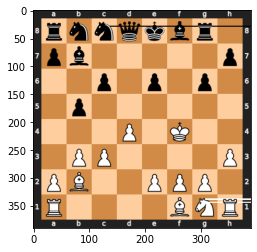

action taken is:  BLC chess piece: wk  num cells: 1  current pos:  (array([3], dtype=int64), array([5], dtype=int64))  New pos: [array([2], dtype=int64), array([4], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/2p1p1p1/1p6/3P4/1PP1K2P/PB2PPP1/R4BNR 




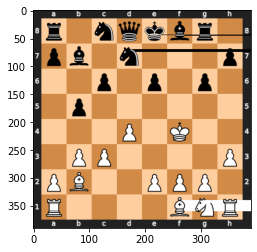

action taken is:  Up chess piece: bk  num cells: 1  current pos:  (array([7], dtype=int64), array([4], dtype=int64))  New pos: [array([6], dtype=int64), array([4], dtype=int64)]
FEN String r1nq1br1/pb1nk2p/2p1p1p1/1p6/3P4/1PP1K2P/PB2PPP1/R4BNR 




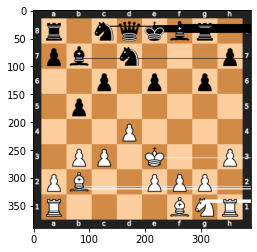

action taken is:  Up chess piece: wp1  num cells: 1  current pos:  (array([1], dtype=int64), array([0], dtype=int64))  New pos: [array([2], dtype=int64), array([0], dtype=int64)]
FEN String r1nq1br1/pb1nk2p/2p1p1p1/1p6/3P4/PPP1K2P/1B2PPP1/R4BNR 




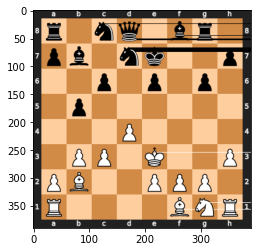

action taken is:  Up chess piece: bp4  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String r1nq1br1/pb1nk2p/2p1p1p1/1p6/3P4/PPP1K2P/1B2PPP1/R4BNR 




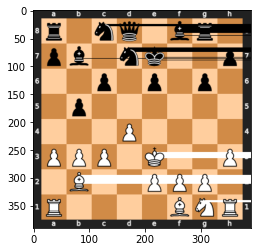

action taken is:  URC chess piece: wq  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String r1nq1br1/pb1nk2p/2p1p1p1/1p6/3P4/PPP1K2P/1B2PPP1/R4BNR 




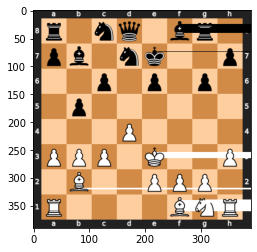

action taken is:  Up chess piece: bp3  num cells: 1  current pos:  (array([5], dtype=int64), array([2], dtype=int64))  New pos: [array([4], dtype=int64), array([2], dtype=int64)]
FEN String r1nq1br1/pb1nk2p/4p1p1/1pp5/3P4/PPP1K2P/1B2PPP1/R4BNR 




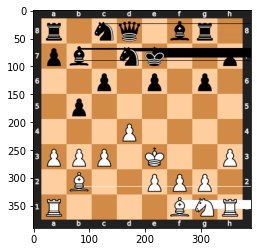

action taken is:  Up chess piece: wp8  num cells: 1  current pos:  (array([2], dtype=int64), array([7], dtype=int64))  New pos: [array([3], dtype=int64), array([7], dtype=int64)]
FEN String r1nq1br1/pb1nk2p/4p1p1/1pp5/3P3P/PPP1K3/1B2PPP1/R4BNR 




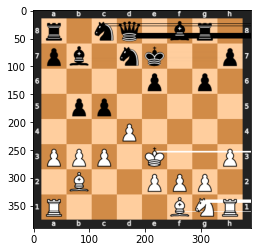

action taken is:  Down chess piece: bk  num cells: 1  current pos:  (array([6], dtype=int64), array([4], dtype=int64))  New pos: [array([7], dtype=int64), array([4], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/4p1p1/1pp5/3P3P/PPP1K3/1B2PPP1/R4BNR 




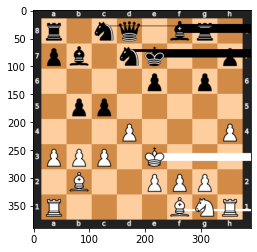

action taken is:  URC chess piece: wk  num cells: 1  current pos:  (array([2], dtype=int64), array([4], dtype=int64))  New pos: [array([3], dtype=int64), array([5], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/4p1p1/1pp5/3P1K1P/PPP5/1B2PPP1/R4BNR 




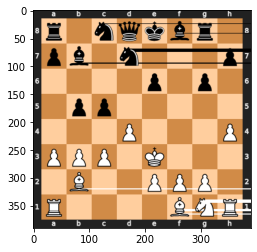

action taken is:  Up chess piece: bp5  num cells: 1  current pos:  (array([5], dtype=int64), array([4], dtype=int64))  New pos: [array([4], dtype=int64), array([4], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/6p1/1pp1p3/3P1K1P/PPP5/1B2PPP1/R4BNR 




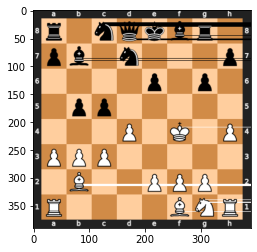

action taken is:  URC chess piece: wq  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/6p1/1pp1p3/3P1K1P/PPP5/1B2PPP1/R4BNR 




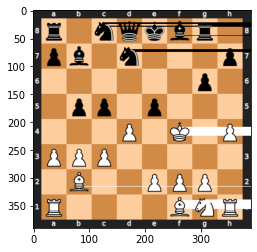

action taken is:  Up chess piece: bp6  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/6p1/1pp1p3/3P1K1P/PPP5/1B2PPP1/R4BNR 




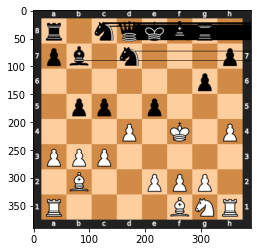

action taken is:  Up chess piece: wp4  num cells: 1  current pos:  (array([3], dtype=int64), array([3], dtype=int64))  New pos: [array([4], dtype=int64), array([3], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/6p1/1ppPp3/5K1P/PPP5/1B2PPP1/R4BNR 




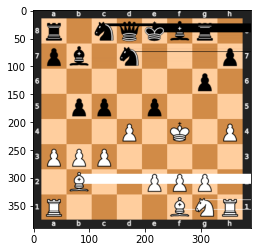

action taken is:  ULC chess piece: bp6  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/6p1/1ppPp3/5K1P/PPP5/1B2PPP1/R4BNR 




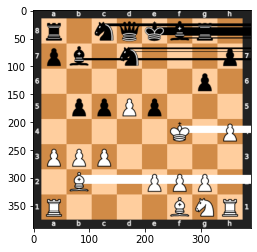

action taken is:  Right chess piece: wq  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String r1nqkbr1/pb1n3p/6p1/1ppPp3/5K1P/PPP5/1B2PPP1/R4BNR 




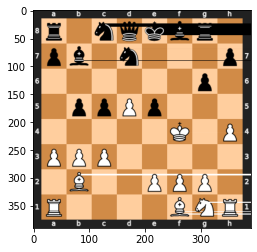

action taken is:  Up chess piece: br2  num cells: 1  current pos:  (array([7], dtype=int64), array([6], dtype=int64))  New pos: [array([6], dtype=int64), array([6], dtype=int64)]
FEN String r1nqkb2/pb1n2rp/6p1/1ppPp3/5K1P/PPP5/1B2PPP1/R4BNR 




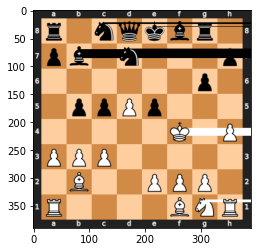

action taken is:  BRC chess piece: wk  num cells: 1  current pos:  (array([3], dtype=int64), array([5], dtype=int64))  New pos: [array([4], dtype=int64), array([4], dtype=int64)]
FEN String r1nqkb2/pb1n2rp/6p1/1ppPK3/7P/PPP5/1B2PPP1/R4BNR 




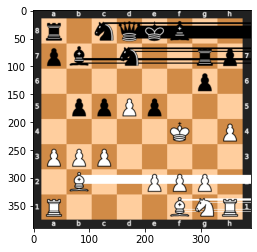

action taken is:  Up chess piece: bp4  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String r1nqkb2/pb1n2rp/6p1/1ppPK3/7P/PPP5/1B2PPP1/R4BNR 




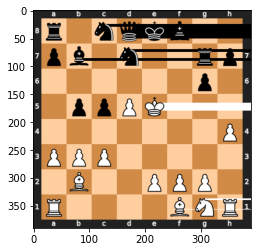

action taken is:  Right chess piece: wr1  num cells: 1  current pos:  (array([0], dtype=int64), array([0], dtype=int64))  New pos: [array([0], dtype=int64), array([1], dtype=int64)]
FEN String r1nqkb2/pb1n2rp/6p1/1ppPK3/7P/PPP5/1B2PPP1/1R3BNR 




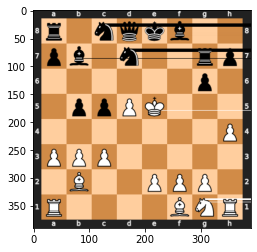

action taken is:  Up chess piece: bp2  num cells: 1  current pos:  (array([4], dtype=int64), array([1], dtype=int64))  New pos: [array([3], dtype=int64), array([1], dtype=int64)]
FEN String r1nqkb2/pb1n2rp/6p1/2pPK3/1p5P/PPP5/1B2PPP1/1R3BNR 




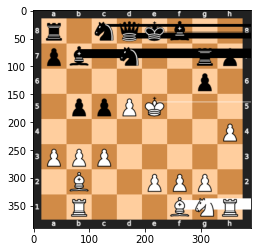

action taken is:  URC chess piece: wp1  num cells: 1  current pos:  (array([2], dtype=int64), array([0], dtype=int64))  New pos: [array([3], dtype=int64), array([1], dtype=int64)]
FEN String r1nqkb2/pb1n2rp/6p1/2pPK3/1P5P/1PP5/1B2PPP1/1R3BNR 




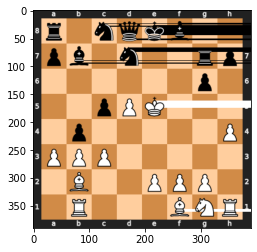

action taken is:  Right chess piece: br2  num cells: 1  current pos:  (array([6], dtype=int64), array([6], dtype=int64))  New pos: [array([6], dtype=int64), array([5], dtype=int64)]
FEN String r1nqkb2/pb1n1r1p/6p1/2pPK3/1P5P/1PP5/1B2PPP1/1R3BNR 




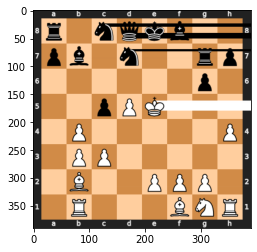

action taken is:  Right chess piece: wq  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String r1nqkb2/pb1n1r1p/6p1/2pPK3/1P5P/1PP5/1B2PPP1/1R3BNR 




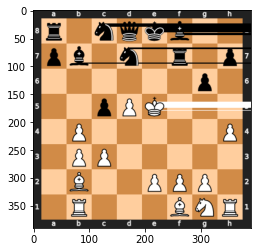

action taken is:  NRU chess piece: bn1  num cells: 1  current pos:  (array([6], dtype=int64), array([3], dtype=int64))  New pos: [array([7], dtype=int64), array([1], dtype=int64)]
FEN String rnnqkb2/pb3r1p/6p1/2pPK3/1P5P/1PP5/1B2PPP1/1R3BNR 




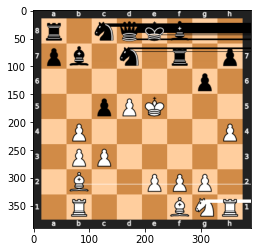

action taken is:  Up chess piece: wp7  num cells: 1  current pos:  (array([1], dtype=int64), array([6], dtype=int64))  New pos: [array([2], dtype=int64), array([6], dtype=int64)]
FEN String rnnqkb2/pb3r1p/6p1/2pPK3/1P5P/1PP3P1/1B2PP2/1R3BNR 




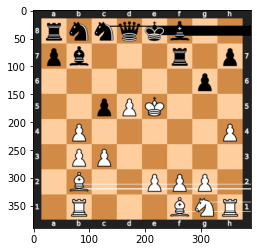

action taken is:  Up chess piece: br2  num cells: 4  current pos:  (array([6], dtype=int64), array([5], dtype=int64))  New pos: [array([2], dtype=int64), array([5], dtype=int64)]
FEN String rnnqkb2/pb5p/6p1/2pPK3/1P5P/1PP2rP1/1B2PP2/1R3BNR 




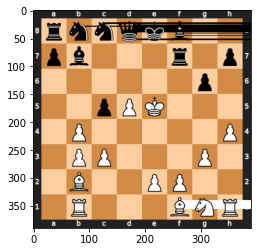

action taken is:  URC chess piece: wb2  num cells: 1  current pos:  (array([0], dtype=int64), array([5], dtype=int64))  New pos: [array([1], dtype=int64), array([6], dtype=int64)]
FEN String rnnqkb2/pb5p/6p1/2pPK3/1P5P/1PP2rP1/1B2PPB1/1R4NR 




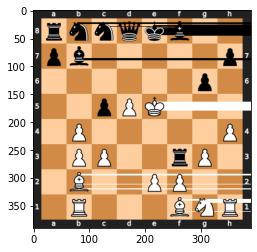

action taken is:  Up chess piece: bp6  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnnqkb2/pb5p/6p1/2pPK3/1P5P/1PP2rP1/1B2PPB1/1R4NR 




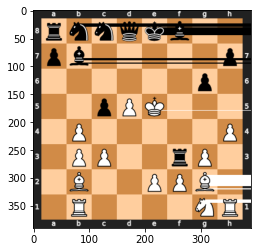

action taken is:  Up chess piece: wp7  num cells: 1  current pos:  (array([2], dtype=int64), array([6], dtype=int64))  New pos: [array([3], dtype=int64), array([6], dtype=int64)]
FEN String rnnqkb2/pb5p/6p1/2pPK3/1P4PP/1PP2r2/1B2PPB1/1R4NR 




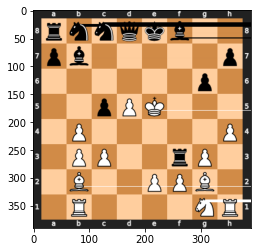

action taken is:  URC chess piece: bp5  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnnqkb2/pb5p/6p1/2pPK3/1P4PP/1PP2r2/1B2PPB1/1R4NR 




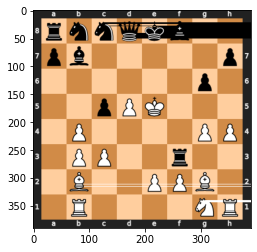

action taken is:  BRC chess piece: wq  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnnqkb2/pb5p/6p1/2pPK3/1P4PP/1PP2r2/1B2PPB1/1R4NR 




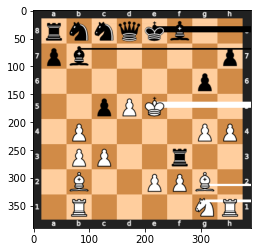

action taken is:  URC chess piece: bp2  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnnqkb2/pb5p/6p1/2pPK3/1P4PP/1PP2r2/1B2PPB1/1R4NR 




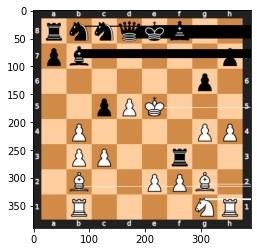

action taken is:  Up chess piece: wp5  num cells: 1  current pos:  (array([1], dtype=int64), array([4], dtype=int64))  New pos: [array([2], dtype=int64), array([4], dtype=int64)]
FEN String rnnqkb2/pb5p/6p1/2pPK3/1P4PP/1PP1Pr2/1B3PB1/1R4NR 




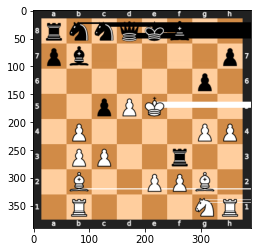

action taken is:  Down chess piece: br2  num cells: 4  current pos:  (array([2], dtype=int64), array([5], dtype=int64))  New pos: [array([6], dtype=int64), array([5], dtype=int64)]
FEN String rnnqkb2/pb3r1p/6p1/2pPK3/1P4PP/1PP1P3/1B3PB1/1R4NR 




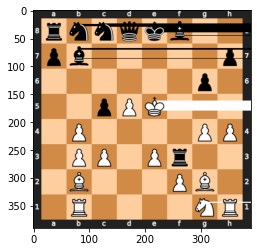

action taken is:  NRU chess piece: wn1  num cells: 1  current pos:  (array([], dtype=int64), array([], dtype=int64))  New pos: [array([], dtype=int64), array([], dtype=int64)]
FEN String rnnqkb2/pb3r1p/6p1/2pPK3/1P4PP/1PP1P3/1B3PB1/1R4NR 




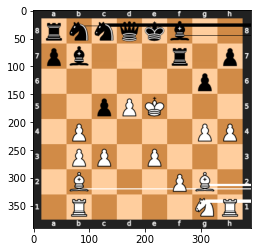

action taken is:  ULC chess piece: bb1  num cells: 1  current pos:  (array([6], dtype=int64), array([1], dtype=int64))  New pos: [array([5], dtype=int64), array([0], dtype=int64)]
FEN String rnnqkb2/p4r1p/b5p1/2pPK3/1P4PP/1PP1P3/1B3PB1/1R4NR 




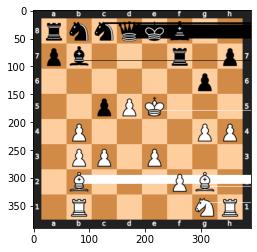

action taken is:  Up chess piece: wp5  num cells: 1  current pos:  (array([2], dtype=int64), array([4], dtype=int64))  New pos: [array([3], dtype=int64), array([4], dtype=int64)]
FEN String rnnqkb2/p4r1p/b5p1/2pPK3/1P2P1PP/1PP5/1B3PB1/1R4NR 




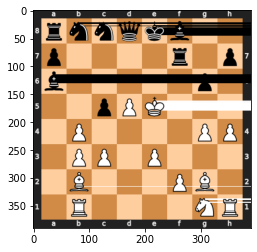

action taken is:  ULC chess piece: bb2  num cells: 2  current pos:  (array([7], dtype=int64), array([5], dtype=int64))  New pos: [array([5], dtype=int64), array([3], dtype=int64)]
FEN String rnnqk3/p4r1p/b2b2p1/2pPK3/1P2P1PP/1PP5/1B3PB1/1R4NR 




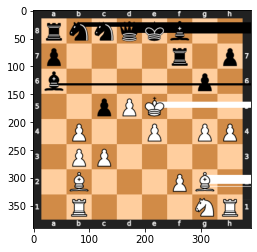

action taken is:  Up chess piece: wp4  num cells: 1  current pos:  (array([4], dtype=int64), array([3], dtype=int64))  New pos: [array([5], dtype=int64), array([3], dtype=int64)]
FEN String rnnqk3/p4r1p/b2P2p1/2p1K3/1P2P1PP/1PP5/1B3PB1/1R4NR 




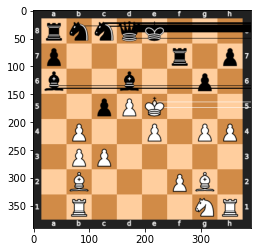

action taken is:  Right chess piece: br2  num cells: 4  current pos:  (array([6], dtype=int64), array([5], dtype=int64))  New pos: [array([6], dtype=int64), array([1], dtype=int64)]
FEN String rnnqk3/pr5p/b2P2p1/2p1K3/1P2P1PP/1PP5/1B3PB1/1R4NR 




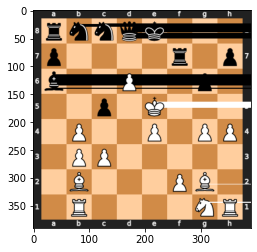

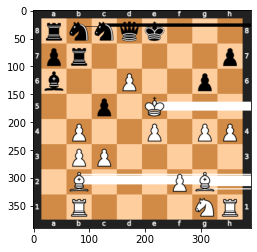

In [18]:
from IPython import display

env = ChessBoard_gym()
obs = env.reset()
num_cells = 1

while True:
    
    # Take a random action
    action = env.action_space.sample()
    obs,reward, done, info = env.step(action)
#     plt.imshow(obs)
#     print("reward: ",reward)
    if (reward >= 1):
#         env.print_board()
        FEN_string =  env.get_FEN()
        print("FEN String",FEN_string, "\n\n")
        board = fen_to_image(FEN_string)
        image = mpimg.imread('current_board.png')
        plt.show()
        plt.imshow(image)
    # Render the game
#     env.render("human")
#     time.sleep(1)
    if done == True:
        break

# # env.close()
# print(reward)

In [6]:
t = np.array([[1,2,3,4],[5,6,7,8]])

In [125]:
pos = [2,4]
x = np.where(t[0,pos[0]:pos[1]] == 4)

In [99]:
x[0],len(x), x[0] ==0

(array([1], dtype=int64), 1, array([False]))

In [100]:
x[0]

array([1], dtype=int64)

In [140]:
int ([7])

TypeError: int() argument must be a string, a bytes-like object or a number, not 'list'